# データの読み込み

In [51]:
#tensorboardの拡張機能読み込み
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
#warningはpythonの標準ライブラリ．
#FutureWarnigが邪魔なので非表示にする．動作に支障が無ければ問題ない．また最適化によって解が収束しないときに出るConvergenceWarningも邪魔なので非表示にする．
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=(FutureWarning, ConvergenceWarning))#対象のwarningsクラスはタプルで渡す必要があるらしい

In [53]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning',
 '/mnt/MachineLearning']


In [182]:
#各種モジュールのimport
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import statistics
from sklearn.metrics import confusion_matrix
import seaborn as sns

from modules import show_mod
from modules.log_controler import ControlLog

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import ReLU, LeakyReLU, PReLU, Softmax
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.backend import clear_session

import optuna

In [55]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = "/mnt/MachineLearning/data"
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
# output_list = glob.glob(data_path+"/CountResults"+"/sitting"+"/count_from2sec_patientAverage.csv")
output_list = glob.glob(data_path+"/summary_20221216.csv")
num_input = len(input_list)
print("data path:", data_path)

data path: /mnt/MachineLearning/data


In [56]:
#input(空調条件等)の読み込み
df_input = None

for input_fname in input_list:
    df_read = pd.read_csv(input_fname, index_col="case_name")
    if df_input is None:
        df_input = df_read
    else:
        df_input = df_input.append(df_read)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN


In [57]:
#壁と人との距離を特徴量に加えてみる

#1~5人目にアクセスするループ
for i in range(1, 6):
    #壁との距離を格納するリスト
    wall = []
    
    #壁との距離を計算するループ
    for idx in df_input.index:
        if df_input.loc[idx, str(i)+"_angle"] == 0:
            wall.append(df_input.loc[idx, "office_size_x"] - df_input.loc[idx, str(i)+"_x"])
        elif df_input.loc[idx, str(i)+"_angle"] == 90:
            wall.append(df_input.loc[idx, "office_size_y"] - df_input.loc[idx, str(i)+"_y"])
        elif df_input.loc[idx, str(i)+"_angle"] == 180:
            wall.append(df_input.loc[idx, str(i)+"_x"])
        elif df_input.loc[idx, str(i)+"_angle"] == 270:
            wall.append(df_input.loc[idx, str(i)+"_y"])
            
    #データフレーム化
    df_wall = pd.DataFrame(wall, index=df_input.index, columns=[str(i)+"_wall"])
    #結合
    df_input = pd.merge(df_input, df_wall, left_index=True, right_index=True)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y,1_wall,2_wall,3_wall,4_wall,5_wall
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,90.0,8.5,6.5,4.25,3.25,4.235,4.235,4.185,4.185,4.185
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,90.0,8.5,6.5,4.25,3.25,4.235,4.235,4.185,4.185,4.185
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,90.0,8.5,6.5,4.25,3.25,4.235,4.235,4.185,4.185,4.185
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,90.0,8.5,6.5,4.25,3.25,4.235,4.235,4.185,4.185,4.185
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,90.0,8.5,6.5,4.25,3.25,4.235,4.235,4.185,4.185,4.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,180.0,6.0,5.5,NaN,NaN,4.734,4.734,4.734,2.984,2.984
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,180.0,6.0,5.5,NaN,NaN,4.734,4.734,4.734,2.984,2.984
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,180.0,6.0,5.5,NaN,NaN,4.734,4.734,4.734,2.984,2.984


In [58]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
delete_cols = ["aircon_position_x", "aircon_position_y"]
df_input.drop(df_input[delete_cols], axis=1, inplace=True)
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,5_y,5_z,5_angle,office_size_x,office_size_y,1_wall,2_wall,3_wall,4_wall,5_wall
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,2.315,1.255,90.0,8.5,6.5,4.235,4.235,4.185,4.185,4.185
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,2.315,1.255,90.0,8.5,6.5,4.235,4.235,4.185,4.185,4.185
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,2.315,1.255,90.0,8.5,6.5,4.235,4.235,4.185,4.185,4.185
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,2.315,1.255,90.0,8.5,6.5,4.235,4.235,4.185,4.185,4.185
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,2.315,1.255,90.0,8.5,6.5,4.235,4.235,4.185,4.185,4.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,0.810,1.255,180.0,6.0,5.5,4.734,4.734,4.734,2.984,2.984
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,0.810,1.255,180.0,6.0,5.5,4.734,4.734,4.734,2.984,2.984
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,0.810,1.255,180.0,6.0,5.5,4.734,4.734,4.734,2.984,2.984


In [59]:
#排気口位置a,b,offをダミー変数化
df_input = pd.get_dummies(df_input, columns=['exhaust'])
df_input

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,office_size_x,office_size_y,1_wall,2_wall,3_wall,4_wall,5_wall,exhaust_a,exhaust_b,exhaust_off
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,8.5,6.5,4.235,4.235,4.185,4.185,4.185,0,1,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,8.5,6.5,4.235,4.235,4.185,4.185,4.185,1,0,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,8.5,6.5,4.235,4.235,4.185,4.185,4.185,0,1,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,8.5,6.5,4.235,4.235,4.185,4.185,4.185,1,0,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,8.5,6.5,4.235,4.235,4.185,4.185,4.185,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,6.0,5.5,4.734,4.734,4.734,2.984,2.984,0,1,0
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,6.0,5.5,4.734,4.734,4.734,2.984,2.984,0,0,1
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,6.0,5.5,4.734,4.734,4.734,2.984,2.984,1,0,0


In [60]:
df_output = pd.read_csv(output_list[0], index_col="case_name")
df_output

,office,aircon,ventilation,exhaust,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand
case_name,,,,,,,,
office2_0_0,office2,0.0,0.0,off,6739.4,204.224242,902.212978,3665.252246
office2_0_164_aout,office2,0.0,164.0,a,7865.4,238.345455,594.272879,3491.917804
office2_0_164_bout,office2,0.0,164.0,b,6049.8,183.327273,432.678869,2354.737770
office2_0_246_aout,office2,0.0,246.0,a,7934.4,240.436364,326.691514,2902.480532
office2_0_246_bout,office2,0.0,246.0,b,7662.0,232.181818,562.535441,2757.177704
...,...,...,...,...,...,...,...,...
office3_960_164_bout,office3,960.0,164.0,b,5117.4,155.072727,779.372047,3209.723128
office3_960_246_aout,office3,960.0,246.0,a,4428.0,134.181818,1662.486855,3671.024626
office3_960_246_bout,office3,960.0,246.0,b,3890.0,117.878788,1343.338436,3968.834276


In [202]:
df_total

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,5_wall,exhaust_a,exhaust_b,exhaust_off,office,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,5629.6,101.893213,160.322463,1381.747088,0
office22_660_246_aout,660,246,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,1,0,0,office22,5321.0,96.307692,148.736772,1108.449584,0
office22_660_82_bout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,4394.8,79.543891,166.156739,1163.417304,0
office22_660_82_aout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,1,0,0,office22,3848.2,69.650679,114.362063,836.464226,0
office22_660_164_bout,660,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,5014.6,90.761991,172.028952,1341.792013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,0,1,0,office6,6504.6,197.109091,198.968053,1139.597671,0
office6_660_0,660,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,0,0,1,office6,7121.0,215.787879,266.319468,1687.575374,1
office6_360_246_aout,360,246,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,1,0,0,office6,6435.6,195.018182,193.841597,1495.725458,0


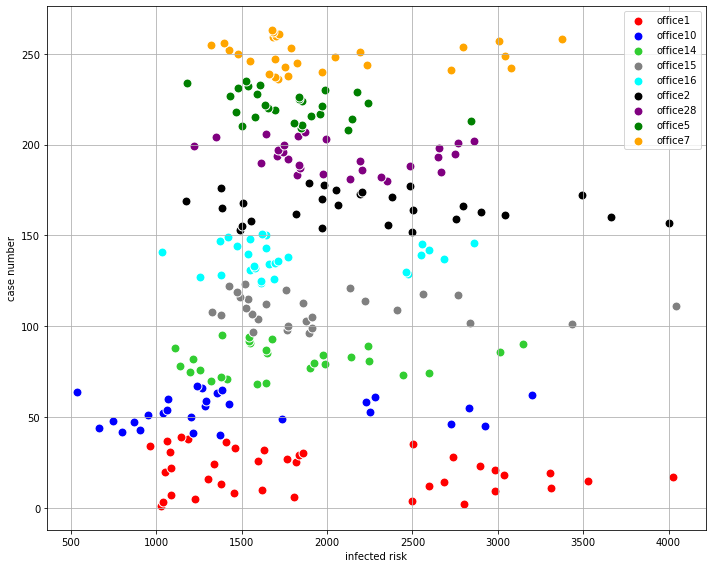

In [206]:
#df_outputの値の幅を見てみる
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_output.index.str.extract("(office+[0-9]{1,2})").to_numpy()
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()

plt.figure(figsize=[10, 8])

#カラーマップ等の準備
markers = ("s", "x", "o", "^", "v", "<", ">", "1", "2", "3", "4", "8")
colors = ("red", "blue", "limegreen", "gray", "cyan", "black", "purple", "green",
          "orange", "yellow", "crimson", "goldenrod", "orchid", "khaki", "darkgray")
start_index = 0

for idx, target_office_name in enumerate(np.unique(office_list)):
    target_office_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
    plt.scatter(df_total.iloc[target_office_index ,31], range(1+start_index, len(target_office_index)+1+start_index), 
                s=80, c=colors[idx], marker=markers[2], edgecolor="white", label=target_office_name)
    start_index += len(target_office_index)
    

plt.ylabel("case number")
plt.xlabel("infected risk")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

# データの前処理

In [168]:
#単に等分してみる
# target_label = "RoI"
target_label = "RoI"
#今回は分類問題なので，感染リスクの値をラベリングして離散化する
RoI_max = df_output.max(axis=0)[target_label]
RoI_min = df_output.min(axis=0)[target_label]

#分類のラベルの数を指定
classification_level = 5

level_defference = (RoI_max - RoI_min) / 5

threshold = []#ラベルをつけるための領域を分ける閾値
for i in range(classification_level+1):
    if i == 0:
        threshold.append(RoI_min)
    elif i == classification_level:
        threshold.append(RoI_max)
    else:
        threshold.append(threshold[i-1] + level_defference)
    
print("threshold")
pprint.pprint(threshold)

label = []
#感染リスクの行列を参照するためのループ
for RoI in df_output[target_label]:
    
    #どの領域に入っているかを探るループ
    for i in range(classification_level):
        #カウント漏れや二重カウントを防ぐため，大小比較を調整
        if i == max(range(classification_level)):
            if RoI >= threshold[max(range(classification_level))]:
                label.append(i)
        elif i == min(range(classification_level)):
            if RoI < threshold[min(range(classification_level)) + 1]:
                label.append(i)
        else:
            if RoI >= threshold[i] and RoI < threshold[i + 1]:
                label.append(i)
                
#データフレーム化
df_label = pd.DataFrame(label, index=df_output.index, columns=["RoI_level"])
#各ラベルの個数カウント
for i in range(classification_level):
    print(f"num RoI_level{i}: {(df_label['RoI_level'] == i).sum()}")
    
#結合
df_output_add = pd.merge(df_output, df_label, left_index=True, right_index=True)
print(f"num null in df:{df_output_add.isnull().values.sum()}\n")#結合が上手く行っていないかどうか確認
df_output_add.head()


threshold
[62.96190476190476,
 98.52225108225107,
 134.0825974025974,
 169.64294372294373,
 205.20329004329005,
 240.76363636363635]
num RoI_level0: 21
num RoI_level1: 71
num RoI_level2: 163
num RoI_level3: 123
num RoI_level4: 53
num null in df:0



,num_drop,volume[ml],RoI,RoI_level
casename,,,,
office2_0_0,6739.4,0.000067,204.224242,3
office2_0_164_aout,7865.4,0.000063,238.345455,4
office2_0_164_bout,6049.8,0.000062,183.327273,3
office2_0_246_aout,7934.4,0.000050,240.436364,4
office2_0_246_bout,7662.0,0.000082,232.181818,4


メモ:\
ラベルを色分けに使って，様々な軸でプロットしたら何かわかりそうな気もする\
値の幅をただ分割レベルに応じて等分したが，これでは外れ値の影響を大きく受ける可能性がある．\
そのため四分位数などを使ったほうが良いかも．

In [62]:
#四分位数バージョン
classification_level = 4
# target_label = "RoI"
target_label = "countTimeMean_sit2stand"

data_describe = df_output[target_label].describe()
print(data_describe)

threshold = data_describe[3:8]
print("\nthreshold")
pprint.pprint(threshold)

label = []
#感染リスクの行列を参照するためのループ
for RoI in df_output[target_label]:
    
    #どの領域に入っているかを探るループ
    for i in range(classification_level):
        #カウント漏れや二重カウントを防ぐため，大小比較を調整
        if i == max(range(classification_level)):
            if RoI >= threshold[max(range(classification_level))]:
                label.append(i)
        elif i == min(range(classification_level)):
            if RoI < threshold[min(range(classification_level)) + 1]:
                label.append(i)
        else:
            if RoI >= threshold[i] and RoI < threshold[i + 1]:
                label.append(i)
                
#データフレーム化
df_label = pd.DataFrame(label, index=df_output.index, columns=["RoI_level"])
#各ラベルの個数カウント
for i in range(classification_level):
    print(f"num RoI_level{i}: {(df_label['RoI_level'] == i).sum()}")

#結合
df_output_add = pd.merge(df_output, df_label, left_index=True, right_index=True)
print(f"num null in df:{df_output_add.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_output_add

count     431.000000
mean     2045.895491
std       758.168789
min       536.517804
25%      1508.278536
50%      1858.661564
75%      2519.456240
max      5176.822962
Name: countTimeMean_sit2stand, dtype: float64

threshold
min     536.517804
25%    1508.278536
50%    1858.661564
75%    2519.456240
max    5176.822962
Name: countTimeMean_sit2stand, dtype: float64
num RoI_level0: 108
num RoI_level1: 107
num RoI_level2: 108
num RoI_level3: 108
num null in df:0


,office,aircon,ventilation,exhaust,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
case_name,,,,,,,,,
office2_0_0,office2,0.0,0.0,off,6739.4,204.224242,902.212978,3665.252246,3
office2_0_164_aout,office2,0.0,164.0,a,7865.4,238.345455,594.272879,3491.917804,3
office2_0_164_bout,office2,0.0,164.0,b,6049.8,183.327273,432.678869,2354.737770,2
office2_0_246_aout,office2,0.0,246.0,a,7934.4,240.436364,326.691514,2902.480532,3
office2_0_246_bout,office2,0.0,246.0,b,7662.0,232.181818,562.535441,2757.177704,3
...,...,...,...,...,...,...,...,...,...
office3_960_164_bout,office3,960.0,164.0,b,5117.4,155.072727,779.372047,3209.723128,3
office3_960_246_aout,office3,960.0,246.0,a,4428.0,134.181818,1662.486855,3671.024626,3
office3_960_246_bout,office3,960.0,246.0,b,3890.0,117.878788,1343.338436,3968.834276,3


In [63]:
delete_cols = ["aircon","ventilation","exhaust"]
df_output_add.drop(df_output_add[delete_cols], axis=1, inplace=True)
df_output_add

,office,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
case_name,,,,,,
office2_0_0,office2,6739.4,204.224242,902.212978,3665.252246,3
office2_0_164_aout,office2,7865.4,238.345455,594.272879,3491.917804,3
office2_0_164_bout,office2,6049.8,183.327273,432.678869,2354.737770,2
office2_0_246_aout,office2,7934.4,240.436364,326.691514,2902.480532,3
office2_0_246_bout,office2,7662.0,232.181818,562.535441,2757.177704,3
...,...,...,...,...,...,...
office3_960_164_bout,office3,5117.4,155.072727,779.372047,3209.723128,3
office3_960_246_aout,office3,4428.0,134.181818,1662.486855,3671.024626,3
office3_960_246_bout,office3,3890.0,117.878788,1343.338436,3968.834276,3


In [153]:
df_total = pd.merge(df_input, df_output_add, left_index=True, right_index=True)
print(f"num null in df:{df_total.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_total

num null in df:0


,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,5_wall,exhaust_a,exhaust_b,exhaust_off,office,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,4.185,0,1,0,office22,5629.6,101.893213,160.322463,1381.747088,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,4.185,1,0,0,office22,5321.0,96.307692,148.736772,1108.449584,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,4.185,0,1,0,office22,4394.8,79.543891,166.156739,1163.417304,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,4.185,1,0,0,office22,3848.2,69.650679,114.362063,836.464226,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,4.185,0,1,0,office22,5014.6,90.761991,172.028952,1341.792013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,2.984,0,1,0,office6,6504.6,197.109091,198.968053,1139.597671,0
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,2.984,0,0,1,office6,7121.0,215.787879,266.319468,1687.575374,1
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,2.984,1,0,0,office6,6435.6,195.018182,193.841597,1495.725458,0


In [154]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, office22_360_164_bout to office6_960_246_bout
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   aircon                   431 non-null    int64  
 1   ventilation              431 non-null    int64  
 2   1_x                      431 non-null    float64
 3   1_y                      431 non-null    float64
 4   1_z                      431 non-null    float64
 5   1_angle                  431 non-null    float64
 6   2_x                      431 non-null    float64
 7   2_y                      431 non-null    float64
 8   2_z                      431 non-null    float64
 9   2_angle                  431 non-null    float64
 10  3_x                      431 non-null    float64
 11  3_y                      431 non-null    float64
 12  3_z                      431 non-null    float64
 13  3_angle                  431 non-null    float64

## 統計分析

In [155]:
#基礎統計量について確認
df_total.describe()

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,4_wall,5_wall,exhaust_a,exhaust_b,exhaust_off,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
count,431.000000,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,...,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,499.071926,139.837587,3.337392,2.765791,1.255000e+00,86.450116,3.618077,3.061318,1.255000e+00,147.215777,...,3.567445,3.453756,0.431555,0.431555,0.136891,6130.170302,161.902247,382.960333,2045.895491,1.501160
std,360.876287,83.985694,1.939957,1.115080,4.446053e-16,83.972153,1.242520,0.838024,4.446053e-16,103.603211,...,1.531204,1.407232,0.495869,0.495869,0.344132,921.844114,36.376848,219.342164,758.168789,1.120371
min,0.000000,0.000000,0.560000,0.810000,1.255000e+00,0.000000,1.266000,0.940000,1.255000e+00,0.000000,...,0.984000,0.984000,0.000000,0.000000,0.000000,2644.400000,62.961905,77.504160,536.517804,0.000000
25%,0.000000,82.000000,1.266000,2.180000,1.255000e+00,0.000000,2.930000,2.540000,1.255000e+00,90.000000,...,2.859000,2.859000,0.000000,0.000000,0.000000,5540.500000,138.530952,237.477704,1508.278536,0.500000
50%,660.000000,164.000000,3.570000,3.016000,1.255000e+00,90.000000,3.285000,3.059000,1.255000e+00,90.000000,...,3.960000,3.960000,0.000000,0.000000,0.000000,6169.400000,159.866667,344.316805,1858.661564,2.000000
75%,960.000000,246.000000,4.760000,3.820000,1.255000e+00,180.000000,4.760000,3.575000,1.255000e+00,270.000000,...,4.734000,4.259000,1.000000,1.000000,0.000000,6791.400000,188.787879,475.919135,2519.456240,2.500000
max,960.000000,246.000000,7.735000,4.515000,1.255000e+00,270.000000,6.260000,4.515000,1.255000e+00,270.000000,...,5.984000,5.734000,1.000000,1.000000,1.000000,8008.600000,240.763636,1814.896506,5176.822962,3.000000


In [156]:
#口のz座標は全て同じであることがわかり特徴量として機能しないので削除
delete_cols = ["1_z","2_z","3_z","4_z","5_z"]
df_total.drop(df_total[delete_cols], axis=1, inplace=True)
df_total

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,5_wall,exhaust_a,exhaust_b,exhaust_off,office,n_from2sec,n_from2sec/S,countTimeMean_sit,countTimeMean_sit2stand,RoI_level
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,5629.6,101.893213,160.322463,1381.747088,0
office22_660_246_aout,660,246,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,1,0,0,office22,5321.0,96.307692,148.736772,1108.449584,0
office22_660_82_bout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,4394.8,79.543891,166.156739,1163.417304,0
office22_660_82_aout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,1,0,0,office22,3848.2,69.650679,114.362063,836.464226,0
office22_660_164_bout,660,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,4.185,0,1,0,office22,5014.6,90.761991,172.028952,1341.792013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,0,1,0,office6,6504.6,197.109091,198.968053,1139.597671,0
office6_660_0,660,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,0,0,1,office6,7121.0,215.787879,266.319468,1687.575374,1
office6_360_246_aout,360,246,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.984,1,0,0,office6,6435.6,195.018182,193.841597,1495.725458,0


In [203]:
#使用するデータセットを絞る
#オフィス形状固定(使用しないデータをテストデータに入れておく)
# not_use_office_name = ["office7", "office15", "office16", "office22", "office8", "office9", "office10", "office14", "office15", "office28"]
#5人固まっている配置の場合
# not_use_office_name = ["office3", "office4", "office5", "office6", "office8", "office9", "office10", "office14", "office15"]
#感染リスクレベルが偏ったオフィスを削除
not_use_office_name = ["office3", "office4", "office22", "office6", "office8", "office9"]
#全データ
# not_use_office_name = []
#正規表現で書いており、.extractはパターンにマッgチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
print(f"office list in data:\n{np.unique(office_list)}")
#リスト内包表記
not_use_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == not_use_office_name)]
#使わないデータ以外を使うデータとする
use_data_bool = np.ones(office_list.shape[0], dtype = bool)
use_data_bool[not_use_data_index] = False
use_data_index = np.arange(office_list.shape[0])[use_data_bool]
df_total = df_total.iloc[use_data_index]

office list in data:
['office1' 'office10' 'office14' 'office15' 'office16' 'office2'
 'office22' 'office28' 'office3' 'office4' 'office5' 'office6' 'office7'
 'office8' 'office9']


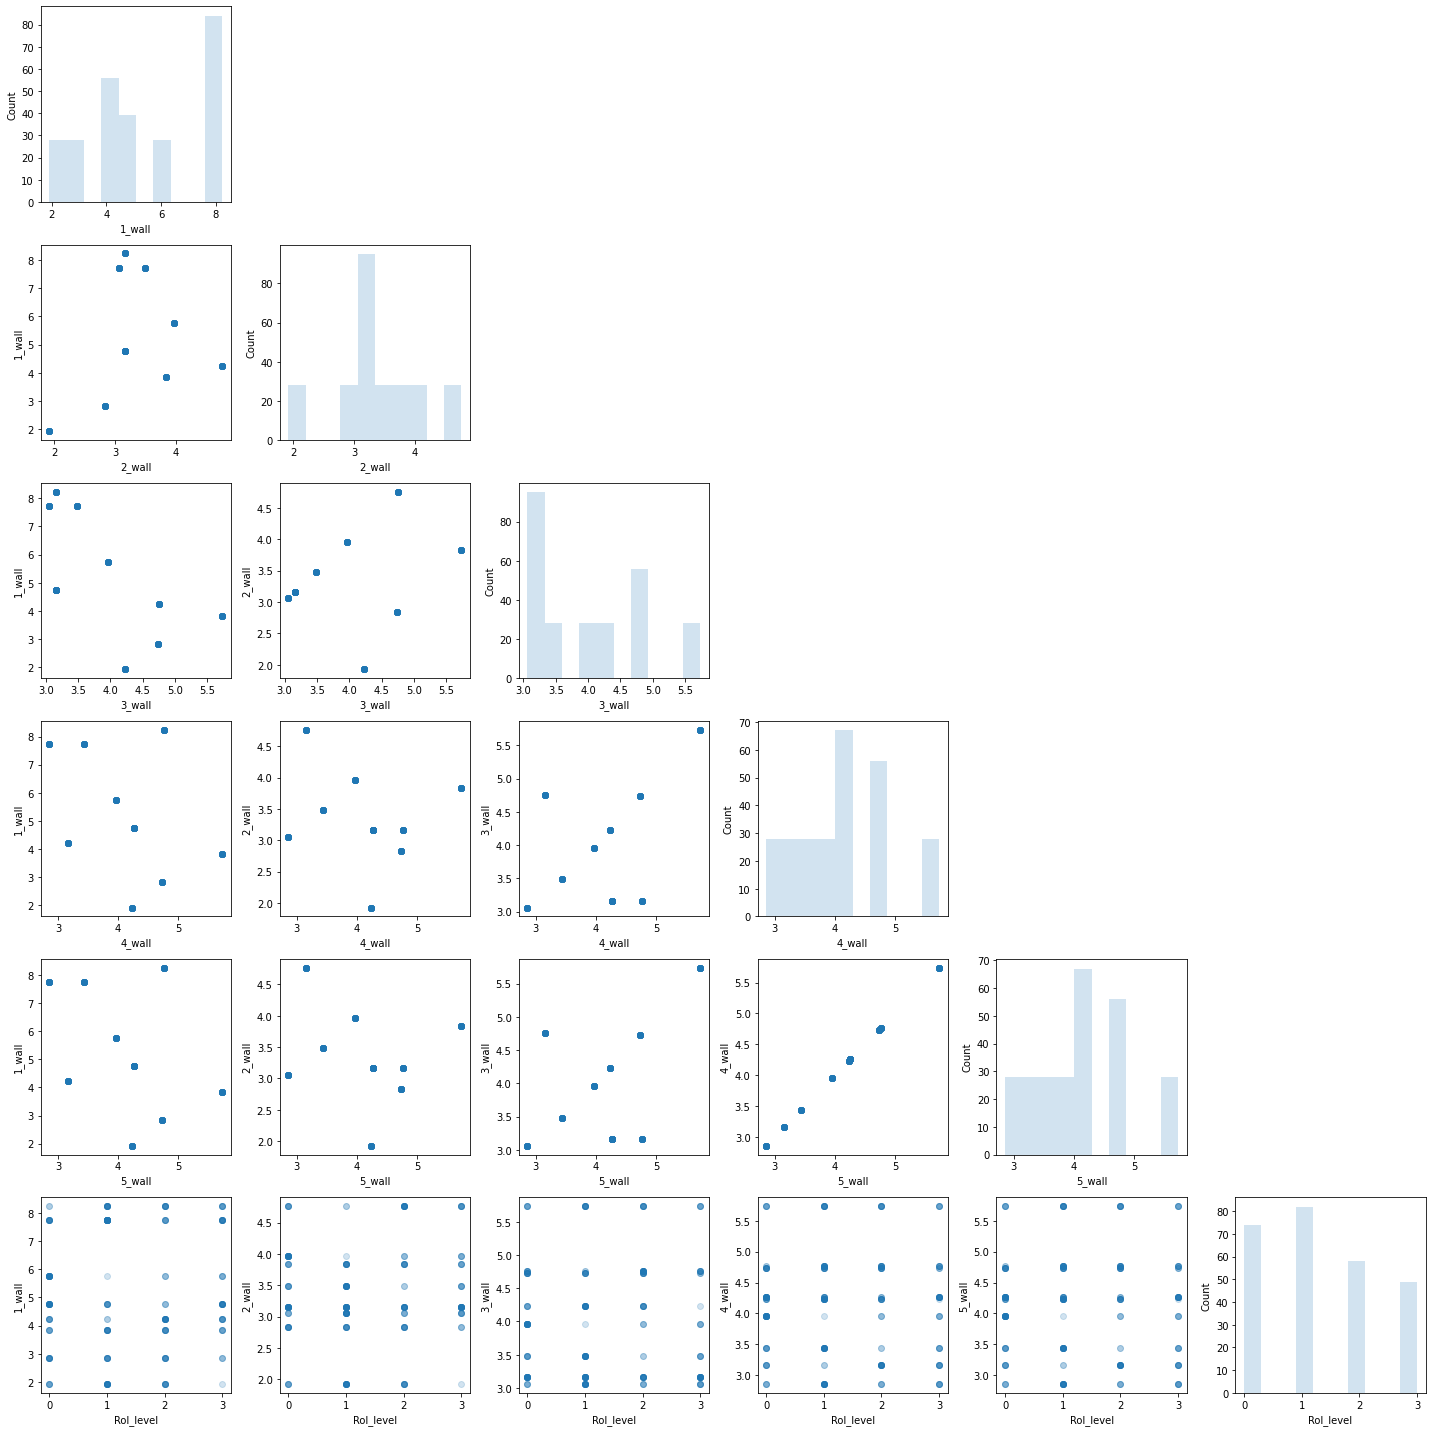

In [29]:
# plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI_level"]
plot_cols = ['1_wall','2_wall','3_wall','4_wall','5_wall',"RoI_level"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
scatterplotmatrix(df_total[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.2)
plt.tight_layout()
plt.show()

In [158]:
#説明変数と目的変数の定義
explanatory_variable =['aircon', 'ventilation', '1_x', '1_y', '1_angle', '2_x', '2_y',
                       '2_angle', '3_x', '3_y', '3_angle', '4_x', '4_y', '4_angle', '5_x', '5_y', '5_angle',
                       'office_size_x','office_size_y', 'exhaust_a', 'exhaust_b', 'exhaust_off',
                       '1_wall','2_wall','3_wall','4_wall','5_wall']
objective_variable = ["RoI_level"]

df_explanatory_variable = df_total[explanatory_variable]
df_objective_variable = df_total[objective_variable]

In [159]:
#説明変数の標準化(only explanatory variable)
#目的変数は標準化する意味がないため，するべきではない．
stdscaler = preprocessing.StandardScaler()
stdscaler.fit(df_explanatory_variable)
np_explanatory_variable_std = stdscaler.transform(df_explanatory_variable)
df_explanatory_variable_std = pd.DataFrame(np_explanatory_variable_std, index=df_explanatory_variable.index, columns=df_explanatory_variable.columns)
df_explanatory_variable_std

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,1_wall,2_wall,3_wall,4_wall,5_wall
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,-0.385821,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.829582,1.499520,-0.871311,1.147695,-0.398249,-0.088799,0.543752,0.382144,0.403782,0.520237
office22_660_246_aout,0.446455,1.265523,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.829582,1.499520,1.147695,-0.871311,-0.398249,-0.088799,0.543752,0.382144,0.403782,0.520237
office22_660_82_bout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.829582,1.499520,-0.871311,1.147695,-0.398249,-0.088799,0.543752,0.382144,0.403782,0.520237
office22_660_82_aout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.829582,1.499520,1.147695,-0.871311,-0.398249,-0.088799,0.543752,0.382144,0.403782,0.520237
office22_660_164_bout,0.446455,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.829582,1.499520,-0.871311,1.147695,-0.398249,-0.088799,0.543752,0.382144,0.403782,0.520237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,1.278731,-0.689460,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,-0.996516,0.172429,-0.871311,1.147695,-0.398249,0.113041,0.839663,0.739508,-0.381480,-0.334204
office6_660_0,0.446455,-1.666952,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,-0.996516,0.172429,-0.871311,-0.871311,2.510993,0.113041,0.839663,0.739508,-0.381480,-0.334204
office6_360_246_aout,-0.385821,1.265523,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,-0.996516,0.172429,1.147695,-0.871311,-0.398249,0.113041,0.839663,0.739508,-0.381480,-0.334204


In [160]:
#使用するデータに含まれる全オフィスのリスト
use_office_list = np.unique(df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy())
print(f"office list in use data:\n{use_office_list}")
#最終テストに用いるオフィスのリスト(最終テストに使用しないものは交差検証用の検証データに使用する)
# test_office_list = ["office1", "office10", "office14", "office15", "office16", "office2", "office28", "office5", "office7"]
test_office_list = use_office_list

office list in use data:
['office1' 'office10' 'office14' 'office15' 'office16' 'office2'
 'office22' 'office28' 'office3' 'office4' 'office5' 'office6' 'office7'
 'office8' 'office9']


In [32]:
#特定のofficeだけテストデータにする
target_office_name = ["office1", "office10"]
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
print(f"office list in data:\n{np.unique(office_list)}")
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

office list in data:
['office1' 'office10' 'office14' 'office15' 'office16' 'office2'
 'office28' 'office5' 'office7']


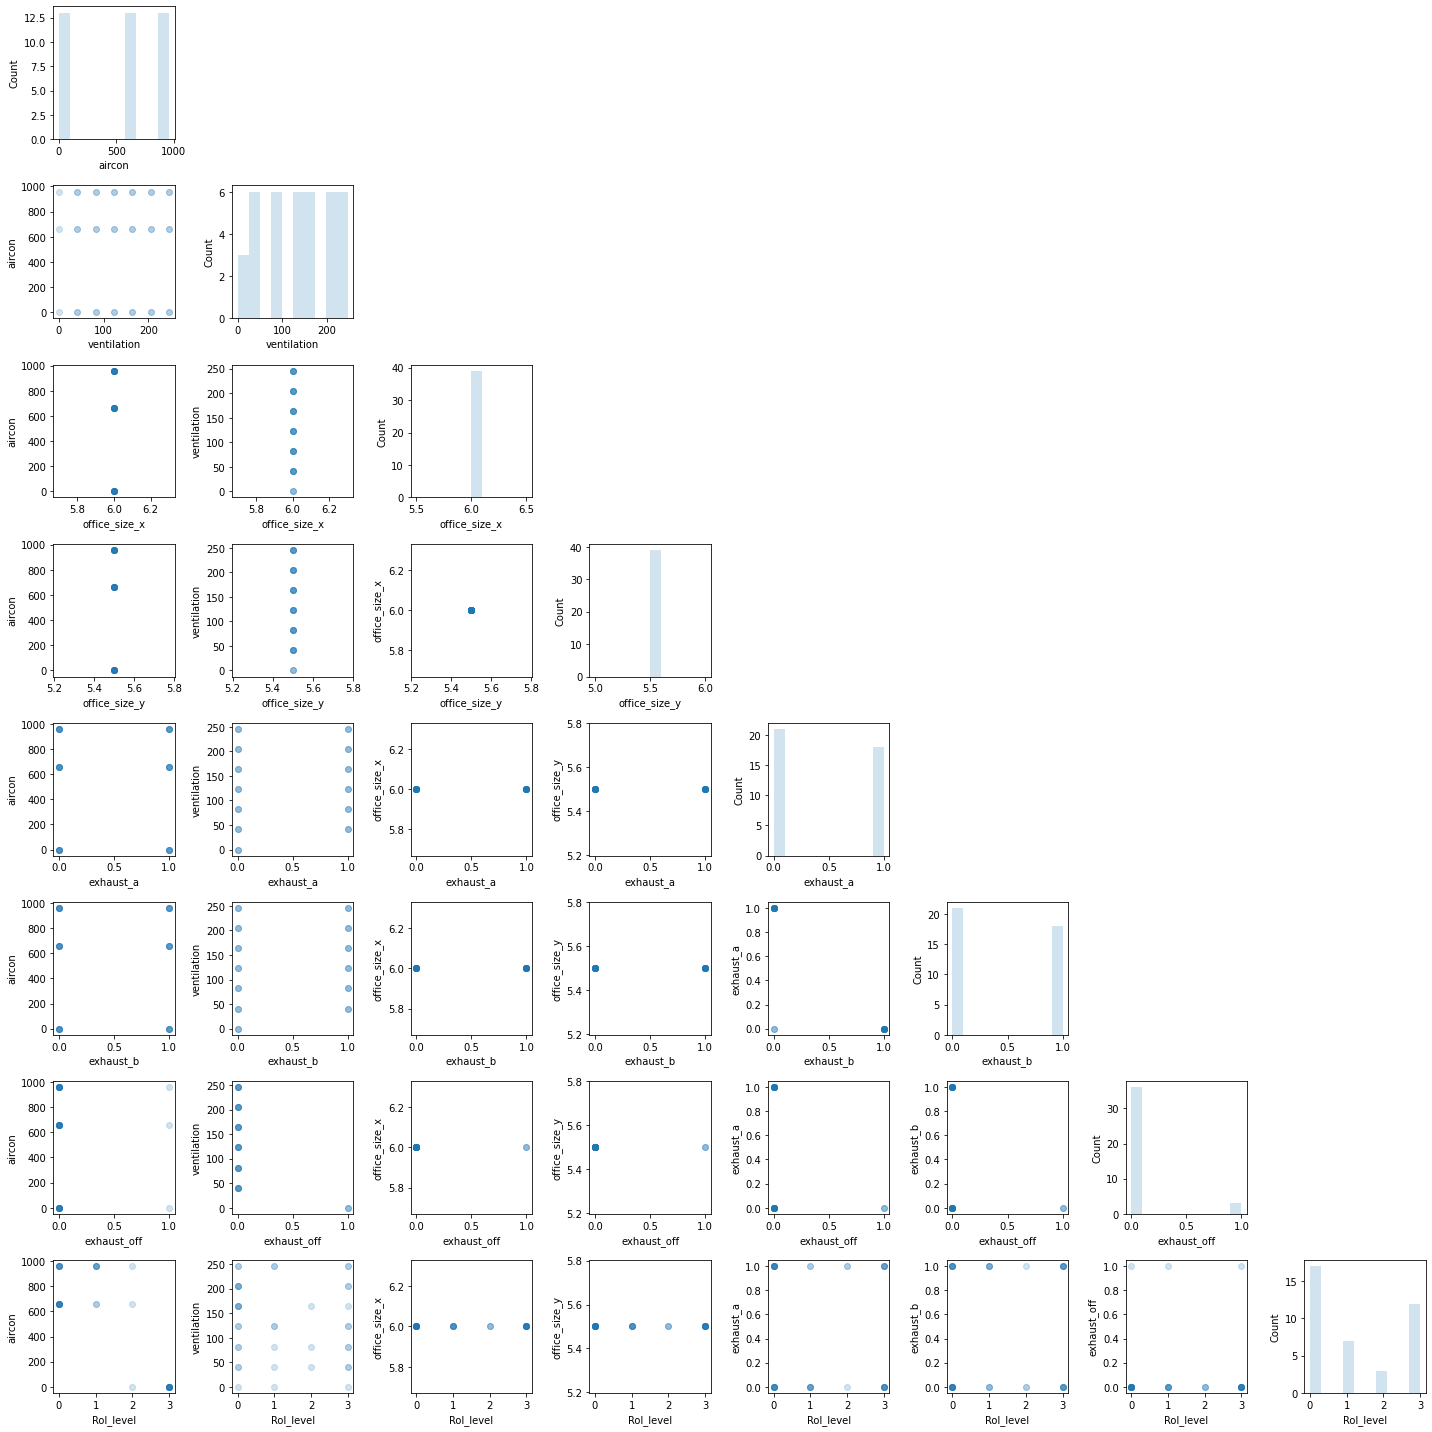

In [33]:
#各オフィスで分けて統計解析してみる(同じ形状のオフィスだけで関係を見たりしたいときに使う)
plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI_level"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
df_target_office = df_total.iloc[test_data_index]
scatterplotmatrix(df_target_office[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.2)
plt.tight_layout()
plt.show()

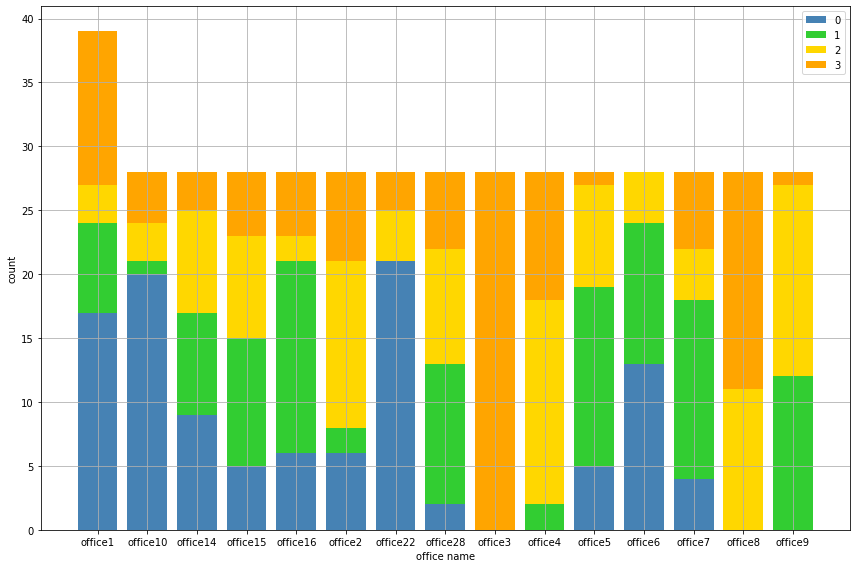

In [161]:
#オフィスごとのRoI_levelをカウントしてみる
unique_office = np.unique(office_list)
# unique_office = np.array(['office1', 'office2', 'office5', 'office7', 'office10', 'office14', 'office15', 'office16', 'office28'])
num_RoI_level = np.zeros((len(unique_office), classification_level))#ラベルのカウント数を保存するリスト

#各オフィスにアクセスするループ
count = 0#ループの回数をカウントする
for selected_office in unique_office:
    #リスト内包表記で選択したオフィスと同名のオフィスのindexを取得
    selected_office_index = [i for i in range(office_list.shape[0]) if all(office_list[i] == selected_office)]
    df_selected_office = df_total.iloc[selected_office_index]
    #各ラベルの個数カウント
    for i in range(classification_level):
        num_RoI_level[count, i] = (df_selected_office['RoI_level'] == i).sum()
        
    count += 1
    

#グラフの描画
colors = ("steelblue", "limegreen", "gold","orange","crimson")
plt.figure(figsize=[12, 8]) 
virtical = num_RoI_level#縦軸の値
horizontal = np.arange(unique_office.shape[0])#横軸の値
for level in range(classification_level):
    plt.bar(x=horizontal, height=virtical[:, level], tick_label=unique_office, bottom=virtical[:, :level].sum(axis=1), color=colors[level])

plt.ylabel("count")
plt.xlabel("office name")
plt.legend(np.arange(classification_level), loc="best")
plt.tight_layout()
plt.grid()
plt.show()

# 分類問題

## SVM

In [35]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

test_explanatory_variable
test_objective_variable

,RoI_level
case_name,
office1_660_41_bout,0
office1_660_205_aout,0
office1_960_82_bout,2
office1_660_164_aout,0
office1_660_82_bout,1
office1_960_41_bout,1
office1_0_205_bout,3
office1_960_41_aout,0
office1_660_246_bout,0


In [391]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの空間設定
        params = {
            "kernel" : trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]), 
            "degree" : trial.suggest_int("degree", 2, 6), 
            "C" : trial.suggest_float("C", 0.0001, 10, log=True)
        }
        
        #決定木
        model = SVC(**params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office7", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index].to_numpy().flatten()
            validate_objective_variable = self.y.iloc[validate_data_index].to_numpy().flatten()

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            
            #評価関数の計算
            scores.append(accuracy_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [392]:
model_name = "SVC"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=200
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
#     study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
#                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
#                                 storage=sqlite_path, load_if_exists=True)
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-12-12/optuna.sqlite3


  0%|          | 0/200 [00:00<?, ?it/s]

study name: 7528


In [393]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.7935897435897435
best params: {'C': 9.285286790469826, 'degree': 2, 'kernel': 'rbf'}


#### 最適化履歴からパラメータを取得

In [282]:
!optuna studies --storage "sqlite:///./OptunaLogs/2022-12-06/optuna.sqlite3"

+------------------------------+---------------+----------+---------------------+
| name                         | direction     | n_trials | datetime_start      |
+------------------------------+---------------+----------+---------------------+
| DecisionTreeClassifier_82559 | ('MAXIMIZE',) |        1 | 2022-12-06 08:26:01 |
| DecisionTreeClassifier_82828 | ('MAXIMIZE',) |        1 | 2022-12-06 08:28:28 |
| DecisionTreeClassifier_8328  | ('MAXIMIZE',) |      100 | 2022-12-06 08:32:08 |
| RandomForestClassifier_84246 | ('MAXIMIZE',) |      200 | 2022-12-06 08:42:46 |
| SVC_91738                    | ('MAXIMIZE',) |      200 | 2022-12-06 09:17:38 |
+------------------------------+---------------+----------+---------------------+


In [283]:
study = optuna.load_study(study_name="SVC_91738", storage="sqlite:///./OptunaLogs/2022-12-06/optuna.sqlite3")

In [284]:
#最適化結果の一覧表示
study_value = []
study_params = []
for i in study.trials:
    study_value.append(i.value)
    study_params.append(i.params)
df_study_value = pd.DataFrame(study_value)

#pandasDataFrameのmin等は帰ってくる型がpandasSeries
min_value = df_study_value.min(axis=0)[0]
min_value_index = df_study_value.idxmin(axis=0)[0]#列の最小値のindexを取得
print("最小値", min_value)
print("最小値のindex", min_value_index)

最小値 0.14194139194139194
最小値のindex 1


In [285]:
#最適化結果のパラメータを一覧取得
use_params = study_params[129]
use_params

{'C': 9.606396383300082, 'degree': 2, 'kernel': 'rbf'}

In [394]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価
best_model = SVC(**study.best_params)
#最適化結果から使ってみたいパラメータを選んでみた
# best_model = SVC(**use_params)

history = best_model.fit(train_explanatory_variable, train_objective_variable.to_numpy().flatten())
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")
# print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
# print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果のプロット
df_result = pd.DataFrame(test_pred, index=test_objective_variable.index, columns=["RoI_pred"])
df_result = pd.merge(test_objective_variable, df_result, left_index=True, right_index=True)
df_result

テストデータを用いた結果
accuracy train score:0.7841191066997518
accuracy test score:0.03571428571428571


,RoI_level,RoI_pred
office10_660_0,0,3
office10_360_0,1,3
office10_960_246_aout,1,3
office10_960_164_aout,1,3
office10_960_164_bout,0,3
office10_660_82_aout,0,3
office10_0_246_bout,1,3
office10_960_82_aout,0,3
office10_0_164_bout,0,3
office10_660_164_bout,0,3


## 決定木

In [397]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,3_angle,4_x,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,1_wall,2_wall,3_wall,4_wall,5_wall
office2_360_82_aout,360,82,3.780,1.265,90.0,4.760,2.740,180.0,4.760,4.190,180.0,2.840,4.590,0.0,2.840,3.140,0.0,6.0,5.5,1,0,0,4.235,4.760,4.760,3.160,3.160
office5_0_82_aout,0,82,4.190,3.575,90.0,2.740,3.575,90.0,1.310,1.266,90.0,2.760,1.266,90.0,4.210,1.266,90.0,6.0,5.5,1,0,0,1.925,1.925,4.234,4.234,4.234
office2_360_82_bout,360,82,3.780,1.265,90.0,4.760,2.740,180.0,4.760,4.190,180.0,2.840,4.590,0.0,2.840,3.140,0.0,6.0,5.5,0,1,0,4.235,4.760,4.760,3.160,3.160
office1_0_123_bout,0,123,4.760,2.180,180.0,3.285,3.160,270.0,1.835,3.160,270.0,1.435,1.241,90.0,2.885,1.241,90.0,6.0,5.5,0,1,0,4.760,3.160,3.160,4.259,4.259
office16_960_82_bout,960,82,7.735,2.505,180.0,6.260,3.485,270.0,4.810,3.485,270.0,5.860,1.566,90.0,4.410,1.566,90.0,9.0,5.0,0,1,0,7.735,3.485,3.485,3.434,3.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,960,164,1.265,3.820,0.0,2.930,2.840,90.0,4.380,2.840,90.0,4.420,4.760,270.0,2.970,4.760,270.0,9.5,6.0,1,0,0,8.235,3.160,3.160,4.760,4.760
office5_360_164_aout,360,164,4.190,3.575,90.0,2.740,3.575,90.0,1.310,1.266,90.0,2.760,1.266,90.0,4.210,1.266,90.0,6.0,5.5,1,0,0,1.925,1.925,4.234,4.234,4.234
office6_0_164_bout,0,164,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,180.0,2.984,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,1,0,4.734,4.734,4.734,2.984,2.984
office28_360_164_bout,360,164,1.265,3.820,0.0,2.930,2.840,90.0,4.380,2.840,90.0,4.420,4.760,270.0,2.970,4.760,270.0,9.5,6.0,0,1,0,8.235,3.160,3.160,4.760,4.760


In [398]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの空間設定
        params = {
            "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth" : trial.suggest_int("max_depth", 2, 100),
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", None]),
        }
        
        #決定木
        model = DecisionTreeClassifier(**params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office7", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            
            #評価関数の計算
            scores.append(accuracy_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [399]:
model_name = "DecisionTreeClassifier"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
#     study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
#                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
#                                 storage=sqlite_path, load_if_exists=True)
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-12-12/optuna.sqlite3


  0%|          | 0/100 [00:00<?, ?it/s]

study name: 71329


In [400]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.9928571428571429
best params: {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt'}


In [401]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価
best_model = DecisionTreeClassifier(**study.best_params)
#最適化結果から使ってみたいパラメータを選んでみた
# best_model = MLP(use_params)

history = best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")
# print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
# print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果のプロット
df_result = pd.DataFrame(test_pred, index=test_objective_variable.index, columns=["RoI_pred"])
df_result = pd.merge(test_objective_variable, df_result, left_index=True, right_index=True)
df_result

テストデータを用いた結果
accuracy train score:1.0
accuracy test score:0.4642857142857143


,RoI_level,RoI_pred
office10_660_0,0,1
office10_360_0,1,2
office10_960_246_aout,1,1
office10_960_164_aout,1,0
office10_960_164_bout,0,0
office10_660_82_aout,0,1
office10_0_246_bout,1,1
office10_960_82_aout,0,0
office10_0_164_bout,0,0
office10_660_164_bout,0,0


メモ：\
評価指標と目的変数は等しい必要はない．実際に評価したいのはこの値だが，数学的な最適化には適していないので\
最適化を行う目的変数としては別の値を使うといったこともある．\
また最適化を行う際の評価指標についてはよく考える必要がある．例えばoffice22においては全て0を出力するだけのモデルでも\
正解率は100%を達成できるため，あまり良い評価指標とは考えられない．どうしよう．

## ランダムフォレスト

In [24]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

test_explanatory_variable
test_objective_variable

,RoI_level
office10_660_0,0
office10_360_0,1
office10_960_246_aout,1
office10_960_164_aout,1
office10_960_164_bout,0
office10_660_82_aout,0
office10_0_246_bout,1
office10_960_82_aout,0
office10_0_164_bout,0
office10_660_164_bout,0


In [25]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの空間設定
        params = {
            "n_estimators" : trial.suggest_int("n_estimators", 10, 1000),
            "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth" : trial.suggest_int("max_depth", 2, 20),
            "max_features" : trial.suggest_categorical("max_features", ["sqrt", None])
        }
        
        #決定木
        model = RandomForestClassifier(**params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office7", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index].to_numpy().flatten()
            validate_objective_variable = self.y.iloc[validate_data_index].to_numpy().flatten()

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            
            #評価関数の計算
            scores.append(accuracy_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [26]:
model_name = "RandomForestClassifier"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=200
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
#     study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
#                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
#                                 storage=sqlite_path, load_if_exists=True)
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-12-12/optuna.sqlite3


  0%|          | 0/200 [00:00<?, ?it/s]

study name: 85155


In [27]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.9928571428571429
best params: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 287}


In [28]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価
best_model = RandomForestClassifier(**study.best_params)
#最適化結果から使ってみたいパラメータを選んでみた
# best_model = MLP(use_params)

history = best_model.fit(train_explanatory_variable, train_objective_variable.to_numpy().flatten())
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")
# print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
# print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果のプロット
df_result = pd.DataFrame(test_pred, index=test_objective_variable.index, columns=["RoI_pred"])
df_result = pd.merge(test_objective_variable, df_result, left_index=True, right_index=True)
df_result

テストデータを用いた結果
accuracy train score:1.0
accuracy test score:0.5714285714285714


,RoI_level,RoI_pred
office10_660_0,0,0
office10_360_0,1,0
office10_960_246_aout,1,0
office10_960_164_aout,1,0
office10_960_164_bout,0,0
office10_660_82_aout,0,0
office10_0_246_bout,1,0
office10_960_82_aout,0,0
office10_0_164_bout,0,0
office10_660_164_bout,0,0


## 勾配ブースティング木

## ニューラルネットワーク

In [162]:
#GPUの環境変数設定
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [163]:
#gpuの確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-01-02 15:48:32.146272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 8586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 648307659509761873
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9003663360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13274629261535580878
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [164]:
#目的変数のラベルをone-hot-encodingする
df_objective_variable_encoded = pd.get_dummies(df_objective_variable, columns=['RoI_level'])
df_objective_variable_encoded

,RoI_level_0,RoI_level_1,RoI_level_2,RoI_level_3
case_name,,,,
office22_360_164_bout,1,0,0,0
office22_660_246_aout,1,0,0,0
office22_660_82_bout,1,0,0,0
office22_660_82_aout,1,0,0,0
office22_660_164_bout,1,0,0,0
...,...,...,...,...
office6_960_82_bout,1,0,0,0
office6_660_0,0,1,0,0
office6_360_246_aout,1,0,0,0


メモ：\
one-hot-encodingは一般的に使用しても問題ないが，分類するクラスの数が多すぎると\
ほとんどの要素が0の行列になり，それが学習に悪影響を与える場合もある．\
決定木系のアルゴリズムにone-hot-encodingは必要ではない．ラベルの大小は関係なく，閾値に従ってただ振り分けるだけだから．

In [50]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable_encoded.iloc[train_data_index]
test_objective_variable = df_objective_variable_encoded.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
# train_explanatory_variable
# train_objective_variable
test_objective_variable

,RoI_level_0,RoI_level_1,RoI_level_2,RoI_level_3
case_name,,,,
office1_660_41_bout,1,0,0,0
office1_660_205_aout,1,0,0,0
office1_960_82_bout,0,0,1,0
office1_660_164_aout,1,0,0,0
office1_660_82_bout,0,1,0,0
office1_960_41_bout,0,1,0,0
office1_0_205_bout,0,0,0,1
office1_960_41_aout,1,0,0,0
office1_660_246_bout,1,0,0,0


**MLPのハイパーパラメータ一覧**
* 入力層に対するドロップアウト
* 中間層の数
* 中間層のユニット数
* 活性化関数
* 中間層のドロップアウト
* BatchNormalization
* オプティマイザ
* バッチサイズ
* エポック数

In [165]:
#base parameter
base_params = {
    "input_dropout" : 0.0,
    "hidden_layers" : 3,
    "hidden_units" : 96,
    "kernel_initializer" : "he_normal",
    "hidden_activation" : "relu",
    "hidden_dropout" : 0.2,
    "batch_norm" : "on",
    "optimizer_type" : "adam", 
    "optimizer_lr" : 0.001,
    "batch_size" : 64,
}

In [166]:
#MLPを定義するクラス
class MLP:
    def __init__(self, params):
        self.params = params
        self.model = None
    
    def fit(self, tr_x, tr_y, va_x, va_y, verbose=0, callback_type="early_stopping"):
        
        #パラメータの読み込み
        input_dropout = self.params["input_dropout"]
        hidden_layers = self.params["hidden_layers"]
        hidden_units = self.params["hidden_units"]
        kernel_initializer = self.params["kernel_initializer"]
        hidden_activation = self.params["hidden_activation"]
        hidden_dropout = self.params["hidden_dropout"]
        batch_norm = self.params["batch_norm"]
        optimizer_type = self.params["optimizer_type"]
        optimizer_lr = self.params["optimizer_lr"]
        batch_size = self.params["batch_size"]
        
        #モデルの定義
        self.model = keras.Sequential()
        
        #入力層，kerasはSequentialモデルを作ったとき最初のlayerにinput_shapeまたはinput_dimで入力の形状をtupleで与える必要がある
        self.model.add(Dropout(rate=input_dropout, input_shape=(tr_x.shape[1],)))
        
        #中間層
        for i in range(hidden_layers):
            #全結合層
            self.model.add(Dense(units=hidden_units, kernel_initializer=kernel_initializer))
            #バッチ正規化の有無
            if batch_norm == "on":
                self.model.add(BatchNormalization())
            #活性化関数の選択
            if hidden_activation == "relu":
                self.model.add(ReLU())
            elif hidden_activation == "leaky_relu":
                self.model.add(LeakyReLU(alpha=0.01))
            elif hidden_activation == "prelu":
                self.model.add(PReLU())
            #指定のモノ以外が来たときには埋め込みエラーを吐く
            else:
                raise NotImplementedError
            #ドロップアウト
            self.model.add(Dropout(rate=hidden_dropout))
        
        #出力層
        self.model.add(Dense(4, kernel_initializer="glorot_normal"))
        self.model.add(Softmax())
        
        #optimizerの選択
        if optimizer_type == "sgd":
            optimizer = optimizers.SGD(learning_rate=optimizer_lr)
        elif optimizer_type == "adam":
            optimizer = optimizers.Adam(learning_rate=optimizer_lr)
        elif optimizer_type == "rmsprop":
            optimizer = optimizers.RMSprop(learning_rate=optimizer_lr)
        #指定のモノ以外が来たときには埋め込みエラーを吐く
        else:
            raise NotImplementedError
        
        #モデルのcompile
        self.model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])
        
        #学習時の設定
        #エポック
        max_epoch = 400

        #callbackの作成．今のところearlystoppingとtensorboardのみ実装
        #定めたパラメータの最小値更新が行われなければ打ち切り
        patience = 40
        if callback_type == "early_stopping":
            callbacks = [EarlyStopping(monitor="val_loss", patience=patience, verbose=verbose, restore_best_weights=False)]
        elif callback_type == "both":
            #決定したMLPの形状表示
            self.model.summary()
            #tensorboard用のログディレクトリ作成
            control_log = ControlLog()
            log_file_name, log_dir_path = control_log.decide_filename(what_log="TensorBoardLogs")
            tb_log_dir = log_dir_path + log_file_name
            callbacks = [EarlyStopping(monitor="val_loss", patience=patience, verbose=verbose, restore_best_weights=True),
                         TensorBoard(log_dir=tb_log_dir, histogram_freq=1)]
            print("\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            print("TensorBoardLogs path:", tb_log_dir)
            print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        history = self.model.fit(
            tr_x, tr_y, epochs=max_epoch, batch_size=batch_size, verbose=verbose,
            validation_data=(va_x, va_y), callbacks=callbacks
        )
        
        return history
        
    def predict(self, x):
        #モデルを使用して予測するときにindexを元データと揃えておかないとmean_squared_errorを計算するときにNanとなりerrorが起きる
        y_pred = pd.DataFrame(self.model.predict(x), index=x.index)
        return y_pred

In [167]:
class Objective:
    
    def __init__(self, X, y, n_trials, val_office_list):
        self.X = X
        self.y = y
        self.val_office_list = val_office_list
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        # Clear clutter from previous Keras session graphs.
        clear_session()
        print("*** clear_session() occured ! ***")
        
        #ハイパーパラメータの空間設定
        params = {
            "input_dropout" : trial.suggest_float("input_dropout", 0.0, 0.2, step=0.05),
            "hidden_layers" : trial.suggest_int("hidden_layers", 3, 10),
            "hidden_units" : trial.suggest_int("hidden_units", 32, 256, step=32),
            "kernel_initializer" : trial.suggest_categorical("kernel_initializer", ["he_normal", "he_uniform", "random_normal"]),
            "hidden_activation" : trial.suggest_categorical("hidden_activation", ["relu", "leaky_relu", "prelu"]),
            "hidden_dropout" : trial.suggest_float("hidden_dropout", 0.0, 0.3, step=0.05),
            "batch_norm" : trial.suggest_categorical("batch_norm", ["on", "off"]),
            "optimizer_type" : trial.suggest_categorical("optimizer_type", ["adam", "rmsprop"]),
            "optimizer_lr" : trial.suggest_float("optimizer_lr", 1e-4, 1e-2, log=True),
            "batch_size" : trial.suggest_int("batch_size", 32, 128, step=32)
        }
        
        #MLP
        model = MLP(params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
       
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in self.val_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[validate_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]
            
            #データをシャッフルする
            train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
            train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
            validate_explanatory_variable = validate_explanatory_variable.sample(frac=1, random_state=1)
            validate_objective_variable = validate_objective_variable.reindex(index=validate_explanatory_variable.index)

            #評価指標の決定，k分割交差検証の実装
            history = model.fit(tr_x=train_explanatory_variable, tr_y=train_objective_variable, 
                                va_x=validate_explanatory_variable, va_y=validate_objective_variable)
                    
            #履歴の最後の１０エポック
            val_loss_list = history.history['val_loss'][-10:] #List of loss
            loss_max = np.max(val_loss_list) #終盤の誤差の最大値（振動抑制が目的）
            
            #評価関数の計算
            scores.append(loss_max)
            
        self.bar.update(1)
        
        return np.mean(scores)

In [188]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        # Clear clutter from previous Keras session graphs.
        clear_session()
        print("*** clear_session() occured ! ***")
        
        #ハイパーパラメータの空間設定
        params = {
            "input_dropout" : trial.suggest_float("input_dropout", 0.0, 0.2, step=0.05),
            "hidden_layers" : trial.suggest_int("hidden_layers", 3, 10),
            "hidden_units" : trial.suggest_int("hidden_units", 32, 256, step=32),
            "kernel_initializer" : trial.suggest_categorical("kernel_initializer", ["he_normal", "he_uniform", "random_normal"]),
            "hidden_activation" : trial.suggest_categorical("hidden_activation", ["relu", "leaky_relu", "prelu"]),
            "hidden_dropout" : trial.suggest_float("hidden_dropout", 0.0, 0.3, step=0.05),
            "batch_norm" : trial.suggest_categorical("batch_norm", ["on", "off"]),
            "optimizer_type" : trial.suggest_categorical("optimizer_type", ["adam", "rmsprop"]),
            "optimizer_lr" : trial.suggest_float("optimizer_lr", 1e-4, 1e-2, log=True),
            "batch_size" : trial.suggest_int("batch_size", 32, 128, step=32)
        }
        
        #MLP
        model = MLP(params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office2", "office3", "office4", "office5", "office6"]
#         validate_office_list = ["office1", "office7", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[validate_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            history = model.fit(tr_x=train_explanatory_variable, tr_y=train_objective_variable, 
                                va_x=validate_explanatory_variable, va_y=validate_objective_variable)
                    
            #履歴の最後の１０エポック
            val_loss_list = history.history['val_loss'][-10:] #List of loss
            loss_max = np.max(val_loss_list) #終盤の誤差の最大値（振動抑制が目的）
            
            #評価関数の計算
            scores.append(loss_max)
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [168]:
model_name = "MLP"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_id = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    """
    最終テスト用オフィスを切り替えながらチューニング実行
    """

    for test_office in test_office_list:
        print("test_office:", test_office)

        study_test_name = test_office + '_is_test'
        study_name = model_name+"_"+study_test_name+"_"+study_id[0]
        
        #交差検証用の検証データに使用するオフィスデータ
        val_office_list = [val_office for val_office in test_office_list if val_office != test_office]
        
        #チューニングに使用するデータセットの決定（標準化するか否かなど）
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        #リスト内包表記
        test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == test_office)]
        #test_data_index以外をtrain_data_indexとする
        train_data_bool = np.ones(office_list.shape[0], dtype = bool)
        train_data_bool[test_data_index] = False
        train_data_index = np.arange(office_list.shape[0])[train_data_bool]
        
        #トレーニングデータ、テストデータの振り分け
        train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
        test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
        train_objective_variable = df_objective_variable_encoded.iloc[train_data_index]
        test_objective_variable = df_objective_variable_encoded.iloc[test_data_index]
    
        #ハイパーパラメータの探索
        objective = Objective(X=train_explanatory_variable, y=train_objective_variable, 
                               n_trials=n_trials, val_office_list=val_office_list)

        #計算資源があるときはランダムサーチ，無ければTPESampler
        #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    #     study = optuna.create_study(directions=["minimize"], study_name=model_name+"_"+study_name[0],
    #                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
    #                                 storage=sqlite_path, load_if_exists=True)
        study = optuna.create_study(directions=["minimize"], study_name=study_name,
                                    sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                    storage=sqlite_path, load_if_exists=True)

        print(f"study name: {study_name}")

        #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
        #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
        study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2023-01-02/optuna.sqlite3
test_office: office1


  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office1_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office10_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office14_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office15_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office16_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office2_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office22_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office28_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clea

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office3_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office4_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office5_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office6_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office7_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office8_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

  0%|          | 0/100 [00:00<?, ?it/s]

study name: MLP_office9_is_test_155020
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear_session() occured ! ***
*** clear

In [ ]:
model_name = "MLP"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
#     study = optuna.create_study(directions=["minimize"], study_name=model_name+"_"+study_name[0],
#                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
#                                 storage=sqlite_path, load_if_exists=True)
    study = optuna.create_study(directions=["minimize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

In [96]:
model_name = "MLP"
study_id = "20214"
test_dict = {}
for test_office in test_office_list:
    print("test_office:", test_office)
    study_test_name = test_office + '_is_test'
    study_name = model_name+"_"+study_test_name+"_"+study_id
    study = optuna.load_study(study_name=study_name, storage="sqlite:///./OptunaLogs/2022-12-30/optuna.sqlite3")
    
    #探索の結果最も良かったscoreとパラメータの表示
    print("探索の結果最良のモデル")
    print(f"best score: {study.best_value}")
    print(f"best params: {study.best_params}")
    
    #最適化結果の一覧表示
    study_value = []
    study_params = []
    for i in study.trials:
        study_value.append(i.value)
        study_params.append(i.params)
    df_study_value = pd.DataFrame(study_value)

    #pandasDataFrameのmin等は帰ってくる型がpandasSeries
    min_value = df_study_value.min(axis=0)[0]
    min_value_index = df_study_value.idxmin(axis=0)[0]#列の最小値のindexを取得
    
    #最適化結果のパラメータを一覧取得
    use_params = study_params[min_value_index]
    best_trial = study.best_trial
    
    #決定したハイパーパラメータを使用して全訓練データで学習，評価
    #最適化結果から使ってみたいパラメータを選んでみた
    best_model = MLP(use_params)
    
    #使用するデータセットの決定（標準化するか否かなど）
    #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
    office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
    #リスト内包表記
    test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == test_office)]
    #test_data_index以外をtrain_data_indexとする
    train_data_bool = np.ones(office_list.shape[0], dtype = bool)
    train_data_bool[test_data_index] = False
    train_data_index = np.arange(office_list.shape[0])[train_data_bool]

    #トレーニングデータ、テストデータの振り分け
    train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
    test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
    train_objective_variable = df_objective_variable_encoded.iloc[train_data_index]
    test_objective_variable = df_objective_variable_encoded.iloc[test_data_index]
    
    #データをシャッフルする
    train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
    train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
    test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
    test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
    
    history = best_model.fit(train_explanatory_variable, train_objective_variable, test_explanatory_variable, test_objective_variable, 
                             verbose=1, callback_type="both")
    train_pred = best_model.predict(train_explanatory_variable)
    test_pred = best_model.predict(test_explanatory_variable)
    print("テストデータを用いた結果")
    print(f"loss train score:{log_loss(train_objective_variable, train_pred)}")
    print(f"loss test score:{log_loss(test_objective_variable, test_pred)}")
     
    test_dict[test_office] = {"best_trial":best_trial, "history":history}

test_office: office1
探索の結果最良のモデル
best score: 1.1956914737820625
best params: {'batch_norm': 'off', 'batch_size': 128, 'hidden_activation': 'leaky_relu', 'hidden_dropout': 0.3, 'hidden_layers': 6, 'hidden_units': 32, 'input_dropout': 0.1, 'kernel_initializer': 'random_normal', 'optimizer_lr': 0.0008571313567878876, 'optimizer_type': 'rmsprop'}
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_127 (Dropout)       (None, 27)                0         
                                                                 
 dense_127 (Dense)           (None, 32)                896       
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 32)                0         
                                                                 
 dropout_128 (Dropout)       (None, 32)                0         
                                      

In [89]:
def plot_history(history:dict, ymax:float=None):
    history_df = pd.DataFrame(history)
    
    loss_df = history_df[["loss", "val_loss"]]
    loss_df.plot()
    plt.xlabel("epochs")
    plt.ylabel("Loss (categorical_crossentropy)")
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.show()

    acc_df = history_df[["categorical_accuracy", "val_categorical_accuracy"]]
    acc_df.plot()
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0., 1.)
    plt.show()

Best trial (test for office1):
  Value: 1.1956914737820625
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: leaky_relu
    hidden_dropout: 0.3
    hidden_layers: 6
    hidden_units: 32
    input_dropout: 0.1
    kernel_initializer: random_normal
    optimizer_lr: 0.0008571313567878876
    optimizer_type: rmsprop


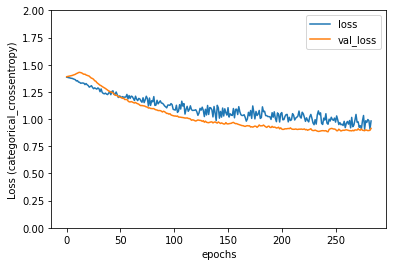

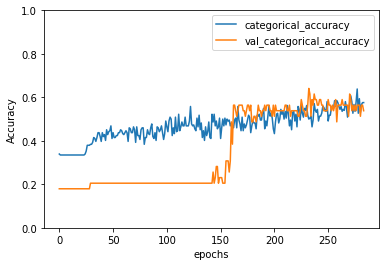

Best trial (test for office10):
  Value: 1.1370602250099182
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: relu
    hidden_dropout: 0.1
    hidden_layers: 5
    hidden_units: 64
    input_dropout: 0.05
    kernel_initializer: random_normal
    optimizer_lr: 0.001427098562908578
    optimizer_type: adam


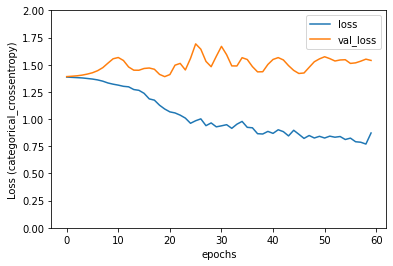

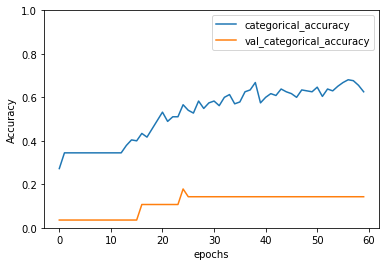

Best trial (test for office14):
  Value: 1.2031256780028343
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: relu
    hidden_dropout: 0.1
    hidden_layers: 8
    hidden_units: 160
    input_dropout: 0.05
    kernel_initializer: random_normal
    optimizer_lr: 0.00012090832579111544
    optimizer_type: adam


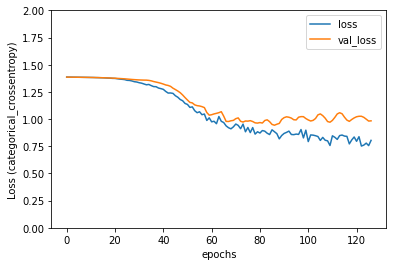

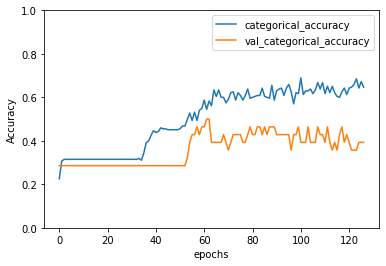

Best trial (test for office15):
  Value: 1.1841093227267265
  Params: 
    batch_norm: on
    batch_size: 128
    hidden_activation: prelu
    hidden_dropout: 0.05
    hidden_layers: 7
    hidden_units: 32
    input_dropout: 0.1
    kernel_initializer: random_normal
    optimizer_lr: 0.0002043276285707872
    optimizer_type: rmsprop


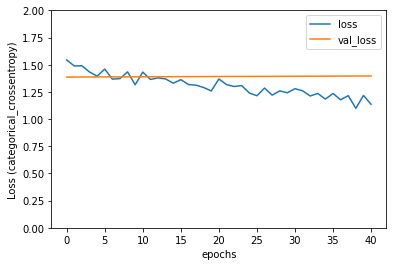

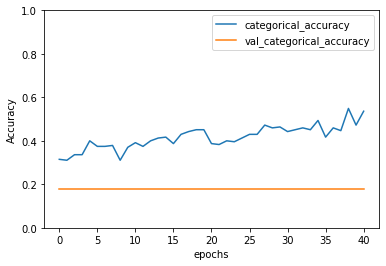

Best trial (test for office16):
  Value: 1.1724078431725502
  Params: 
    batch_norm: on
    batch_size: 128
    hidden_activation: prelu
    hidden_dropout: 0.0
    hidden_layers: 3
    hidden_units: 64
    input_dropout: 0.15000000000000002
    kernel_initializer: he_normal
    optimizer_lr: 0.001308198057450652
    optimizer_type: adam


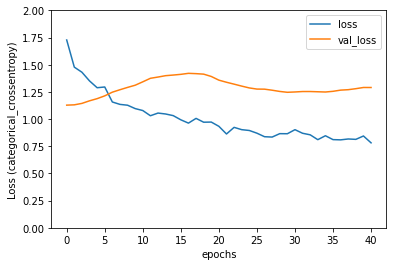

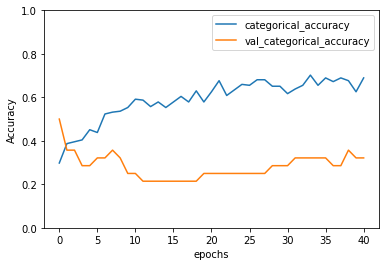

Best trial (test for office2):
  Value: 1.123474396765232
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: relu
    hidden_dropout: 0.2
    hidden_layers: 3
    hidden_units: 96
    input_dropout: 0.1
    kernel_initializer: he_normal
    optimizer_lr: 0.0026414852780584776
    optimizer_type: adam


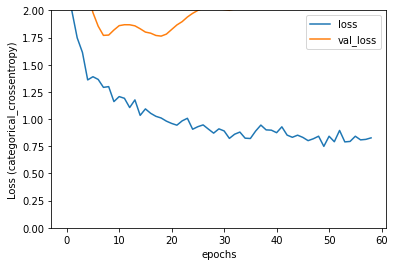

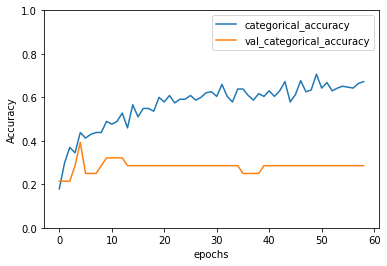

Best trial (test for office28):
  Value: 1.1953567117452621
  Params: 
    batch_norm: on
    batch_size: 128
    hidden_activation: prelu
    hidden_dropout: 0.2
    hidden_layers: 4
    hidden_units: 192
    input_dropout: 0.0
    kernel_initializer: he_uniform
    optimizer_lr: 0.0001044471404820105
    optimizer_type: rmsprop


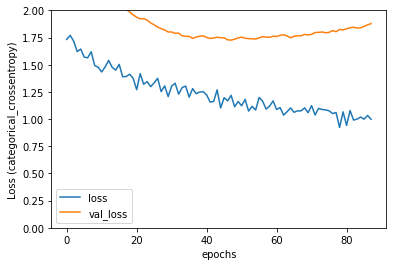

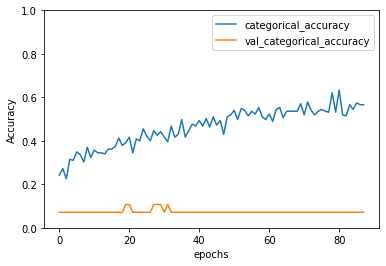

Best trial (test for office5):
  Value: 1.1915570348501205
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: relu
    hidden_dropout: 0.15000000000000002
    hidden_layers: 3
    hidden_units: 96
    input_dropout: 0.0
    kernel_initializer: random_normal
    optimizer_lr: 0.0011373454891015619
    optimizer_type: adam


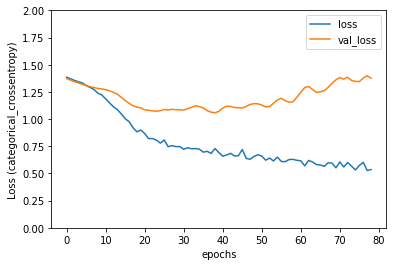

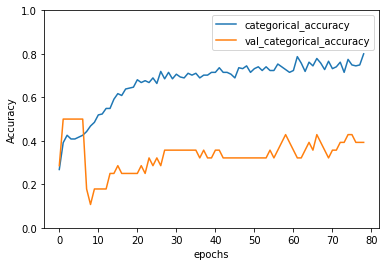

Best trial (test for office7):
  Value: 1.1873245909810066
  Params: 
    batch_norm: on
    batch_size: 64
    hidden_activation: leaky_relu
    hidden_dropout: 0.1
    hidden_layers: 4
    hidden_units: 32
    input_dropout: 0.15000000000000002
    kernel_initializer: random_normal
    optimizer_lr: 0.0008540665712472171
    optimizer_type: rmsprop


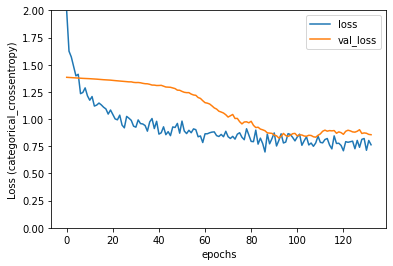

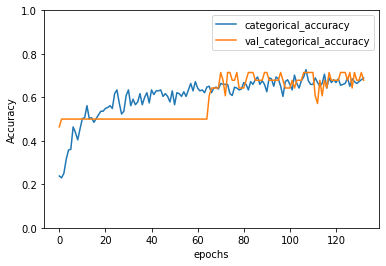

In [97]:
for test_office, result_dict in test_dict.items():
    print(f"Best trial (test for {test_office}):")
    best_trial = result_dict["best_trial"]

    print("  Value: {}".format(best_trial.value))

    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))
        
        
    plot_history(result_dict["history"].history, ymax=2.)

In [98]:
model_name = "MLP"
study_id = "20214"
test_dict = {}
test_office = "office1"
print("test_office:", test_office)
study_test_name = test_office + '_is_test'
study_name = model_name+"_"+study_test_name+"_"+study_id
study = optuna.load_study(study_name=study_name, storage="sqlite:///./OptunaLogs/2022-12-30/optuna.sqlite3")

#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

#最適化結果の一覧表示
study_value = []
study_params = []
for i in study.trials:
    study_value.append(i.value)
    study_params.append(i.params)
df_study_value = pd.DataFrame(study_value)

#pandasDataFrameのmin等は帰ってくる型がpandasSeries
min_value = df_study_value.min(axis=0)[0]
min_value_index = df_study_value.idxmin(axis=0)[0]#列の最小値のindexを取得

#最適化結果のパラメータを一覧取得
use_params = study_params[min_value_index]
best_trial = study.best_trial

#決定したハイパーパラメータを使用して全訓練データで学習，評価
#最適化結果から使ってみたいパラメータを選んでみた
best_model = MLP(use_params)

#使用するデータセットの決定（標準化するか否かなど）
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == test_office)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable_encoded.iloc[train_data_index]
test_objective_variable = df_objective_variable_encoded.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

history = best_model.fit(train_explanatory_variable, train_objective_variable, test_explanatory_variable, test_objective_variable, 
                         verbose=1, callback_type="both")
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"loss train score:{log_loss(train_objective_variable, train_pred)}")
print(f"loss test score:{log_loss(test_objective_variable, test_pred)}")

test_dict[test_office] = {"best_trial":best_trial, "history":history}

test_office: office1
探索の結果最良のモデル
best score: 1.1956914737820625
best params: {'batch_norm': 'off', 'batch_size': 128, 'hidden_activation': 'leaky_relu', 'hidden_dropout': 0.3, 'hidden_layers': 6, 'hidden_units': 32, 'input_dropout': 0.1, 'kernel_initializer': 'random_normal', 'optimizer_lr': 0.0008571313567878876, 'optimizer_type': 'rmsprop'}
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_179 (Dropout)       (None, 27)                0         
                                                                 
 dense_179 (Dense)           (None, 32)                896       
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 32)                0         
                                                                 
 dropout_180 (Dropout)       (None, 32)                0         
                                      

Best trial (test for office1):
  Value: 1.1956914737820625
  Params: 
    batch_norm: off
    batch_size: 128
    hidden_activation: leaky_relu
    hidden_dropout: 0.3
    hidden_layers: 6
    hidden_units: 32
    input_dropout: 0.1
    kernel_initializer: random_normal
    optimizer_lr: 0.0008571313567878876
    optimizer_type: rmsprop


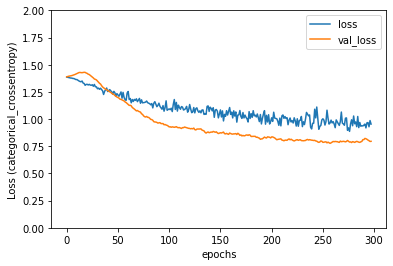

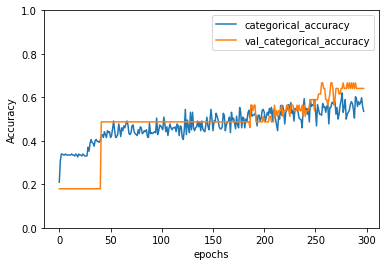

In [110]:
for test_office, result_dict in test_dict.items():
    print(f"Best trial (test for {test_office}):")
    best_trial = result_dict["best_trial"]

    print("  Value: {}".format(best_trial.value))

    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))
        
        
    plot_history(result_dict["history"].history, ymax=2.)

In [123]:
train_pred_round = train_pred.to_numpy().argmax(axis=1)
result_train_df = pd.DataFrame({"correct":train_objective_variable.to_numpy().argmax(axis=1), "predict":train_pred_round})
result_train_df["match"] = (result_train_df["correct"] == result_train_df["predict"])
test_pred_round = test_pred.to_numpy().argmax(axis=1)
result_test_df = pd.DataFrame({"correct":test_objective_variable.to_numpy().argmax(axis=1), "predict":test_pred_round})
result_test_df["match"] = (result_test_df["correct"] == result_test_df["predict"])
result_train_df

,correct,predict,match
0,2,1,False
1,2,3,False
2,2,1,False
3,3,3,True
4,2,2,True
...,...,...,...
219,3,3,True
220,1,1,True
221,2,2,True
222,2,2,True


In [109]:
print("train_acc: ", accuracy_score(train_objective_variable.to_numpy().argmax(axis=1), train_pred_round))
print("test_acc: ", accuracy_score(test_objective_variable.to_numpy().argmax(axis=1), test_pred_round))

train_acc:  0.6339285714285714
test_acc:  0.6666666666666666


<AxesSubplot:>

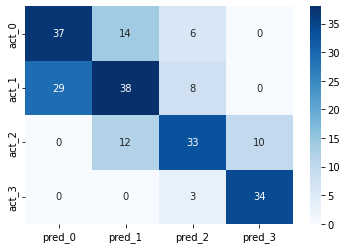

In [107]:
labels = [0, 1, 2, 3] # ラベルの順序を指定
cm = confusion_matrix(train_objective_variable.to_numpy().argmax(axis=1), train_pred_round, labels=labels)
columns_labels = ["pred_" + str(l) for l in labels]
index_labels = ["act_" + str(l) for l in labels]
cm = pd.DataFrame(cm, columns=columns_labels, index=index_labels)

sns.heatmap(cm, annot=True, cmap='Blues')

In [120]:
print(classification_report(train_objective_variable.to_numpy().argmax(axis=1), train_pred_round, labels=labels))

              precision    recall  f1-score   support

           0       0.56      0.65      0.60        57
           1       0.59      0.51      0.55        75
           2       0.66      0.60      0.63        55
           3       0.77      0.92      0.84        37

    accuracy                           0.63       224
   macro avg       0.65      0.67      0.65       224
weighted avg       0.63      0.63      0.63       224



<AxesSubplot:>

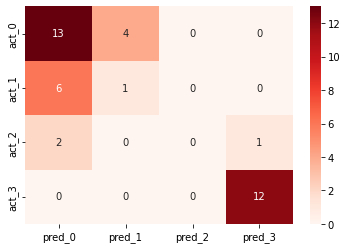

In [108]:
labels = [0, 1, 2, 3] # ラベルの順序を指定
cm = confusion_matrix(test_objective_variable.to_numpy().argmax(axis=1), test_pred_round, labels=labels)
columns_labels = ["pred_" + str(l) for l in labels]
index_labels = ["act_" + str(l) for l in labels]
cm = pd.DataFrame(cm, columns=columns_labels, index=index_labels)

sns.heatmap(cm, annot=True, cmap='Reds')

In [115]:
print(classification_report(test_objective_variable.to_numpy().argmax(axis=1), test_pred_round))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        17
           1       0.20      0.14      0.17         7
           2       0.00      0.00      0.00         3
           3       0.92      1.00      0.96        12

    accuracy                           0.67        39
   macro avg       0.44      0.48      0.45        39
weighted avg       0.59      0.67      0.62        39



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [196]:
#make roc curve
train_one_hot = preprocessing.label_binarize(result_train_df["correct"], classes=labels)
test_one_hot = preprocessing.label_binarize(result_test_df["correct"], classes=labels)

n_classes = 4
fpr = {}#1-specificity
tpr = {}#sensitivity
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_one_hot[:, i], test_pred[i])
#     fpr[i], tpr[i], _ = roc_curve(train_one_hot[:, i], train_pred[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"auc class{i}:{roc_auc[i]}")

auc class0:0.7459893048128341
auc class1:0.6383928571428571
auc class2:0.4259259259259259
auc class3:0.9691358024691359


auc macro: 0.7147203867868697
auc micro: 0.8963401271093578


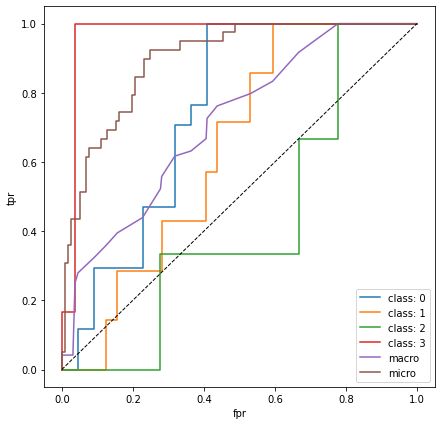

In [197]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr = mean_tpr / len(labels)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print("auc macro:", roc_auc["macro"])

fpr["micro"], tpr["micro"], _ = roc_curve(test_one_hot.ravel(), test_pred.to_numpy().ravel())
# fpr["micro"], tpr["micro"], _ = roc_curve(train_one_hot.ravel(), train_pred.to_numpy().ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("auc micro:", roc_auc["micro"])

plt.figure(figsize=(7, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"class: {i}")
plt.plot(fpr["macro"], tpr["macro"], label="macro")
plt.plot(fpr["micro"], tpr["micro"], label="micro")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

In [83]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 1.1873245909810066
best params: {'batch_norm': 'on', 'batch_size': 64, 'hidden_activation': 'leaky_relu', 'hidden_dropout': 0.1, 'hidden_layers': 4, 'hidden_units': 32, 'input_dropout': 0.15000000000000002, 'kernel_initializer': 'random_normal', 'optimizer_lr': 0.0008540665712472171, 'optimizer_type': 'rmsprop'}


In [191]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価
best_model = MLP(study.best_params)
#最適化結果から使ってみたいパラメータを選んでみた
# best_model = MLP(use_params)

history = best_model.fit(train_explanatory_variable, train_objective_variable, test_explanatory_variable, test_objective_variable, 
                         verbose=1, callback_type="both")
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"loss train score:{log_loss(train_objective_variable, train_pred)}")
print(f"loss test score:{log_loss(test_objective_variable, test_pred)}")
# print(f"accuracy train score:{accuracy_score(train_objective_variable, train_pred)}")
# print(f"accuracy test score:{accuracy_score(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果のプロット
df_result = pd.DataFrame(test_pred, index=test_objective_variable.index)
df_result = pd.merge(test_objective_variable, df_result, left_index=True, right_index=True)
df_result

Model: "sequential_4016"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_29964 (Dropout)     (None, 27)                0         
                                                                 
 dense_29964 (Dense)         (None, 96)                2688      
                                                                 
 re_lu_8359 (ReLU)           (None, 96)                0         
                                                                 
 dropout_29965 (Dropout)     (None, 96)                0         
                                                                 
 dense_29965 (Dense)         (None, 96)                9312      
                                                                 
 re_lu_8360 (ReLU)           (None, 96)                0         
                                                                 
 dropout_29966 (Dropout)     (None, 96)            

,RoI_level_0,RoI_level_1,RoI_level_2,RoI_level_3,0,1,2,3
office1_660_41_bout,0,0,1,0,0.096059,0.135078,0.259668,0.509195
office1_660_205_aout,0,0,1,0,0.064739,0.108352,0.258968,0.567941
office1_960_82_bout,0,0,0,1,0.074969,0.112906,0.251031,0.561094
office1_660_164_aout,0,1,0,0,0.071081,0.112435,0.263830,0.552654
office1_660_82_bout,0,0,0,1,0.091904,0.132995,0.261192,0.513909
office1_960_41_bout,0,0,0,1,0.074838,0.112973,0.249509,0.562680
office1_0_205_bout,0,0,0,1,0.068215,0.121854,0.265448,0.544483
office1_960_41_aout,0,0,1,0,0.082597,0.129559,0.267906,0.519938
office1_660_246_bout,0,0,1,0,0.067333,0.111245,0.255817,0.565605
office1_960_123_bout,0,0,0,1,0.073305,0.112377,0.250487,0.563831


In [192]:
#TensorBoardの起動
%tensorboard --logdir "./TensorBoardLogs/2022-12-23/73259"